In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from glob import glob
from IPython.display import clear_output
from matplotlib import ticker
from scipy.stats import gmean
from sklearn.metrics import confusion_matrix
from src.data.synthetic_gen import DataLoader
from src.models.classification import NeuralNetClassifier
from src.models.classification.evaluate_models import ClassificationAnalysis
from src.models.classification.train_models import ClassificationTraining
from src.visualization.styles.formatting import errorbar_kwargs
from src.utils.constants import K_FOLDS

tf.random.set_seed(13)

In [2]:
classifier_model_name = "Rede Neural #8"
generator_model_name = "WGAN #11"

training = ClassificationTraining()
analysis = ClassificationAnalysis()

results = training.load_training_models()
indices = analysis.load_performance_indices()

output = [out for out in results["outputs"] if out["model_name"] == classifier_model_name][0]
model_id = [i for i, out in enumerate(results["outputs"]) if out["model_name"] == classifier_model_name][0]

print(f"Modelo: {output['model_name']}, ID: {model_id}")
print("    params:", output["params"])
print("    opt:   ", output["opt"])


Modelo: Rede Neural #8, ID: 23
    params: {'hidden_units': [64, 64], 'activation': 'relu'}
    opt:    {'lr': 0.001, 'epochs': 500, 'batch_size': 32}


### Training best neural network

In [3]:
# Train best neural network
# Rede Neural #8
learning_rate = output["opt"]["lr"]
epochs = output["opt"]["epochs"]
batch_size = output["opt"]["batch_size"]

params = {"hidden_units": output["params"]["hidden_units"], "activation": output["params"]["activation"]}

dataset_sizes = [1, 2, 3, 5, 10]

# for dataset_size in dataset_sizes:
#     dl = DataLoader(problem="classification", model_name=generator_model_name, dataset_size=dataset_size)
#     datasets, minmax = dl.load_cross_validation_datasets()

#     train_data = datasets["train"]
#     valid_data = datasets["valid"]

#     models = []
#     for i, (train, valid) in enumerate(zip(train_data, valid_data)):

#         train_features, train_labels = train["features"], train["targets"]
#         valid_features, valid_labels = valid["features"], valid["targets"]

#         features, labels = train_features.values, train_labels.values
#         train_ds = tf.data.Dataset.from_tensor_slices((features, labels)).shuffle(10000).batch(batch_size)

#         features, labels = valid_features.values, valid_labels.values
#         valid_ds = tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

#         loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#         accuracy = tf.keras.metrics.CategoricalAccuracy()
#         optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#         callbacks = [
#             tf.keras.callbacks.ReduceLROnPlateau(),
#             # patience 10% of epochs size
#             tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=50),
#         ]
#         model = NeuralNetClassifier(**params)
#         model.compile(optimizer=optimizer, loss=loss_object, metrics=[accuracy])
#         h = model.fit(
#             train_ds,
#             epochs=epochs,
#             validation_data=valid_ds,
#             callbacks=callbacks,
#             verbose=1,  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
#         )

#         models.append(model)

#         models_folder = os.path.join(
#             "data",
#             "models",
#             "classification_with_synthetic_dataset",
#             generator_model_name,
#             f"{dataset_size}to1",
#         )
#         if not os.path.isdir(models_folder):
#             os.makedirs(models_folder)

#         # model.save(os.path.join(models_folder, f"model_fold={i+1}.keras"))
#         clear_output(wait=True)

### Evaluation

In [4]:
# Load saved models trained with synthetic dataset
def calculate_performances_values(folder, dataset_size, generator_model):
    dl = DataLoader(problem="classification", model_name=generator_model, dataset_size=dataset_size)
    datasets, _ = dl.load_cross_validation_datasets()

    valid_data = datasets["valid"]

    models = [tf.keras.models.load_model(model_file) for model_file in glob(os.path.join(folder, "*.keras"))]

    confusion_matrix_values = []
    accuracies = []
    sensitivities = []
    sp_indexes = []

    for valid, model in zip(valid_data, models):
        valid_features, valid_labels = valid["features"], valid["targets"]

        X_valid = tf.convert_to_tensor(valid_features)
        probs = tf.convert_to_tensor(valid_labels)
        y_valid = tf.argmax(probs, axis=1)

        logits = model(X_valid)
        probs_hat = tf.nn.softmax(logits)
        y_valid_hat = tf.argmax(probs_hat, axis=1)

        # Confusion matrix
        cm = confusion_matrix(y_valid, y_valid_hat)
        confusion_matrix_values.append(cm)

        # Accuracy
        accuracies.append(np.diag(cm).sum() / cm.sum())

        # Sensitivity
        sens = np.diag(cm) / cm.sum(axis=1)
        sensitivities.append(sens)

        # SP Index
        sp_indexes.append(np.sqrt(np.mean(sens) * gmean(sens)))

    confusion_matrix_values = np.array(confusion_matrix_values)
    accuracies = np.array(accuracies)
    sensitivities = np.array(sensitivities)
    sp_indexes = np.array(sp_indexes)

    print(f"Dataset {dataset_size}to1")
    print(
        f"Accuracy = {(100 * accuracies).mean():.2f} \\textpm {(100 * accuracies).std() / np.sqrt(K_FOLDS - 1):.2f} %"
    )

    mean_sens = (100 * sensitivities).mean(axis=0)
    std_err_sens = (100 * sensitivities).std(axis=0) / np.sqrt(K_FOLDS - 1)
    print(f"Sensitivity [V] = {mean_sens[0]:.2f} \\textpm {std_err_sens[0]:.2f} %")
    print(f"Sensitivity [VL] = {mean_sens[1]:.2f} \\textpm {std_err_sens[1]:.2f} %")
    print(f"Sensitivity [L] = {mean_sens[2]:.2f} \\textpm {std_err_sens[2]:.2f} %")

    print(
        f"SP Index = {(100 * sp_indexes).mean():.2f} \\textpm {(100 * sp_indexes).std() / np.sqrt(K_FOLDS - 1):.2f} %"
    )
    print()

    return {
        "confusion_matrix": confusion_matrix_values,
        "accuracies": accuracies,
        "sensitivities": sensitivities,
        "sp_indexes": sp_indexes,
    }, {
        "Sensitivity [V]": f"{mean_sens[0]:.2f} \\textpm {std_err_sens[0]:.2f}",
        "Sensitivity [VL]": f"{mean_sens[1]:.2f} \\textpm {std_err_sens[1]:.2f}",
        "Sensitivity [L]": f"{mean_sens[2]:.2f} \\textpm {std_err_sens[2]:.2f}",
        "SP Index": f"{(100 * sp_indexes).mean():.2f} \\textpm {(100 * sp_indexes).std() / np.sqrt(K_FOLDS - 1):.2f}",
    }

In [5]:
def create_results(model_name):
    models_folder = glob(
        os.path.join(
            "data",
            "models",
            "classification_with_synthetic_dataset",
            model_name,
            "*",
        )
    )
    models_folder = sorted(models_folder, key=lambda p: int(os.path.split(p)[-1].split("to")[0]))
    table = []

    print(f"Classificador: {classifier_model_name}, Gerador: {model_name}")
    indices_dict = {}
    for folder in models_folder:
        dataset_size = int(os.path.split(folder)[-1].split("to")[0])
        values, table_values = calculate_performances_values(folder, dataset_size, model_name)
        indices_dict[f"Sintético {dataset_size}x"] = values
        table.append(table_values)

    def highlight(s, props=""):
        if s.name == "num_params":
            return np.where(s == np.min(s.values), props, "")
        else:
            mu = s.apply(lambda row: float(row.split(r" \textpm ")[0]))
            if s.name == "cross_entropy":
                return np.where(mu == np.min(mu.values), props, "")
            else:
                return np.where(mu == np.max(mu.values), props, "")

    table = pd.DataFrame.from_records(table).style.apply(highlight, props="font-weight:bold;", axis=0)
    table.to_latex(
        os.path.join(
            "data",
            "models",
            "classification_with_synthetic_dataset",
            f"performance_indices_table_{model_name}.tex",
        ),
        hrules=True,
        convert_css=True,
        column_format="lccccc",
    )
    return indices_dict


wgan_indices_dict = create_results(model_name="WGAN #11")

Classificador: Rede Neural #8, Gerador: WGAN #11
Dataset 1to1
Accuracy = 84.55 \textpm 2.83 %
Sensitivity [V] = 87.50 \textpm 2.66 %
Sensitivity [VL] = 76.32 \textpm 6.26 %
Sensitivity [L] = 90.28 \textpm 6.16 %
SP Index = 84.39 \textpm 2.89 %

Dataset 2to1
Accuracy = 86.82 \textpm 2.02 %
Sensitivity [V] = 90.28 \textpm 2.66 %
Sensitivity [VL] = 81.58 \textpm 1.52 %
Sensitivity [L] = 88.89 \textpm 5.56 %
SP Index = 86.79 \textpm 2.07 %

Dataset 3to1
Accuracy = 89.55 \textpm 2.50 %
Sensitivity [V] = 87.50 \textpm 1.39 %
Sensitivity [VL] = 88.16 \textpm 5.43 %
Sensitivity [L] = 93.06 \textpm 1.39 %
SP Index = 89.51 \textpm 2.46 %

Dataset 5to1
Accuracy = 91.36 \textpm 1.87 %
Sensitivity [V] = 93.06 \textpm 1.39 %
Sensitivity [VL] = 88.16 \textpm 6.92 %
Sensitivity [L] = 93.06 \textpm 2.66 %
SP Index = 91.26 \textpm 1.90 %

Dataset 10to1
Accuracy = 95.00 \textpm 1.14 %
Sensitivity [V] = 94.44 \textpm 2.27 %
Sensitivity [VL] = 94.74 \textpm 3.04 %
Sensitivity [L] = 95.83 \textpm 1.39 %
SP 

In [6]:
dirichlet_indices_dict = create_results(model_name="Dirichlet Estimator")

Classificador: Rede Neural #8, Gerador: Dirichlet Estimator
Dataset 1to1
Accuracy = 73.64 \textpm 3.82 %
Sensitivity [V] = 76.39 \textpm 6.94 %
Sensitivity [VL] = 57.89 \textpm 5.68 %
Sensitivity [L] = 87.50 \textpm 5.26 %
SP Index = 73.17 \textpm 4.00 %

Dataset 2to1
Accuracy = 78.18 \textpm 3.71 %
Sensitivity [V] = 77.78 \textpm 4.54 %
Sensitivity [VL] = 73.68 \textpm 7.44 %
Sensitivity [L] = 83.33 \textpm 5.07 %
SP Index = 78.02 \textpm 3.69 %

Dataset 3to1
Accuracy = 81.82 \textpm 2.68 %
Sensitivity [V] = 77.78 \textpm 2.27 %
Sensitivity [VL] = 80.26 \textpm 3.31 %
Sensitivity [L] = 87.50 \textpm 3.50 %
SP Index = 81.77 \textpm 2.66 %

Dataset 5to1
Accuracy = 79.55 \textpm 1.87 %
Sensitivity [V] = 73.61 \textpm 2.66 %
Sensitivity [VL] = 76.32 \textpm 6.62 %
Sensitivity [L] = 88.89 \textpm 3.93 %
SP Index = 79.28 \textpm 1.91 %

Dataset 10to1
Accuracy = 88.18 \textpm 1.57 %
Sensitivity [V] = 80.56 \textpm 4.81 %
Sensitivity [VL] = 89.47 \textpm 2.15 %
Sensitivity [L] = 94.44 \textpm

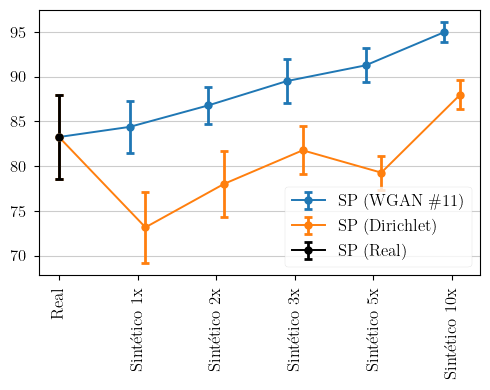

In [7]:
name = classifier_model_name.replace("#", "\#")

labels = [f"Real", *wgan_indices_dict.keys()]

x = np.arange(len(labels))
wgan_x = x - 0.1
dirichet_x = x + 0.1

wgan_x[0] = x[0]
dirichet_x[0] = x[0]

f, ax = plt.subplots(figsize=(5, 4))

wgan_sp_idx = np.r_[[indices["sp_index"][:, model_id]], np.array([i["sp_indexes"] for i in wgan_indices_dict.values()])]
dirichlet_sp_idx = np.r_[
    [indices["sp_index"][:, model_id]], np.array([i["sp_indexes"] for i in dirichlet_indices_dict.values()])
]

wgan_y = wgan_sp_idx.mean(axis=1) * 100
wgan_y_err = (wgan_sp_idx.std(axis=1) / np.sqrt(K_FOLDS - 1)) * 100

dirichlet_y = dirichlet_sp_idx.mean(axis=1) * 100
dirichlet_y_err = (dirichlet_sp_idx.std(axis=1) / np.sqrt(K_FOLDS - 1)) * 100

ax.errorbar(wgan_x, wgan_y, wgan_y_err, label="SP (WGAN \#11)", c="tab:blue", **errorbar_kwargs)
ax.errorbar(dirichet_x, dirichlet_y, dirichlet_y_err, label="SP (Dirichlet)", c="tab:orange", **errorbar_kwargs)
ax.errorbar([wgan_x[0]], [wgan_y[0]], [wgan_y_err[0]], label="SP (Real)", c="black", **errorbar_kwargs)
ax.yaxis.grid()
ax.set_xticks(x, labels, rotation=90, ha="center")
ax.legend(loc="lower right")

f.tight_layout()
plt.savefig(os.path.join("data", "images", "sp_index_errorbar_plot_synthetic.png"), dpi=600)
plt.show()

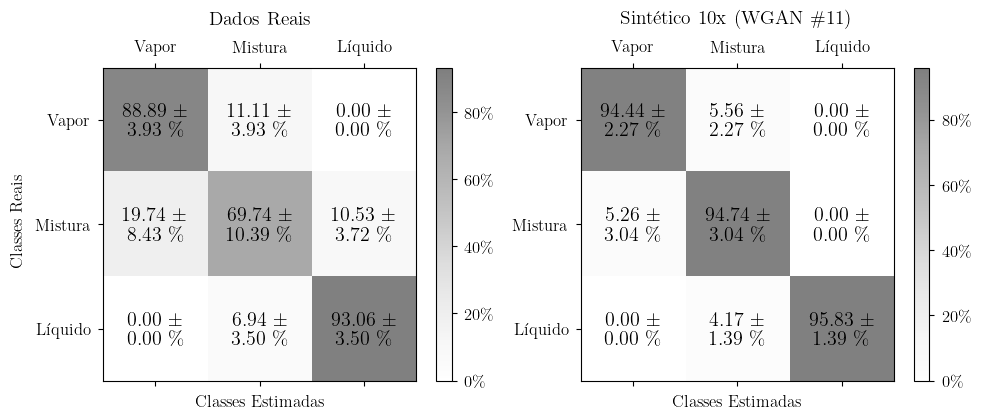

In [15]:
def plot_confusion_matrix(cm, ax, model_name):
    cm = cm / np.sum(cm, axis=2)[:, :, None]
    cm_mean = np.mean(cm, axis=0)
    cm_std = np.std(cm, axis=0) / np.sqrt(K_FOLDS - 1)

    ms = ax.matshow(cm_mean, alpha=0.5, cmap="Greys")
    for ii in range(cm_mean.shape[0]):
        for jj in range(cm_mean.shape[1]):
            text = f"{cm_mean[ii, jj] * 100:1.2f} \\textpm \n {cm_std[ii, jj] * 100:1.2f} \%"
            ax.text(x=jj, y=ii, s=text, va="center", ha="center", size="x-large")

    cbar = ax.figure.colorbar(ms, ax=ax, shrink=0.675, format=ticker.PercentFormatter(xmax=1))
    ax.set_xlabel("Classes Estimadas")
    # ax.set_ylabel("Classes Reais")
    ax.set_title(model_name.replace("#", "\#"))

    # 0: gas, 1: mix, 2: oil
    ax.set_xticks([0, 1, 2], ["Vapor", "Mistura", "Líquido"])
    ax.set_yticks([0, 1, 2], ["Vapor", "Mistura", "Líquido"])
    ax.grid(False)

f, axs = plt.subplots(1, 2, figsize=(10, 5))

cm_real = indices["confusion_matrix"][:, model_id, :, :].astype("int16")
cm_synthetic_10to1 = wgan_indices_dict["Sintético 10x"]["confusion_matrix"].astype("int16")
plot_confusion_matrix(cm_real, axs[0], "Dados Reais")
plot_confusion_matrix(cm_synthetic_10to1, axs[1], "Sintético 10x (WGAN #11)")

f.supylabel("Classes Reais")
f.tight_layout()

plt.savefig(os.path.join("data", "images", "comparing_confusion_matrices_wgan_synthetic.png"), dpi=600)
plt.show()